# 9.5 Applications of Parameter Estimation

## Application 1: A/B Testing with Bayesian Inference

### Problem

You're a data scientist at a company testing two website designs:
- **Design A** (control): Current design
- **Design B** (treatment): New design

**Goal**: Which design has a higher click-through rate (CTR)?

### Frequentist Approach (Review)

In [1]:
import numpy as np
from scipy import stats

np.random.seed(42)

# Simulate data
n_A = 1000  # Visitors to A
n_B = 1000  # Visitors to B

# True CTRs (unknown in practice)
true_p_A = 0.10
true_p_B = 0.12

# Generate clicks
clicks_A = np.random.binomial(n_A, true_p_A)
clicks_B = np.random.binomial(n_B, true_p_B)

print("A/B Testing: Frequentist vs. Bayesian")
print("="*70)
print(f"Design A: {clicks_A}/{n_A} clicks (CTR = {clicks_A/n_A:.3f})")
print(f"Design B: {clicks_B}/{n_B} clicks (CTR = {clicks_B/n_B:.3f})")
print()

# Frequentist test: Two-proportion z-test
p_A_hat = clicks_A / n_A
p_B_hat = clicks_B / n_B
p_pooled = (clicks_A + clicks_B) / (n_A + n_B)

se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_A + 1/n_B))
z = (p_B_hat - p_A_hat) / se
p_value = 1 - stats.norm.cdf(z)  # One-sided

print("FREQUENTIST APPROACH")
print("-" * 70)
print(f"p̂_A = {p_A_hat:.4f}")
print(f"p̂_B = {p_B_hat:.4f}")
print(f"Difference: {p_B_hat - p_A_hat:.4f}")
print(f"Z-statistic: {z:.3f}")
print(f"P-value (one-sided): {p_value:.4f}")
if p_value < 0.05:
    print("Decision: Reject H₀, B is better than A (p < 0.05)")
else:
    print("Decision: Insufficient evidence that B is better")

A/B Testing: Frequentist vs. Bayesian
Design A: 96/1000 clicks (CTR = 0.096)
Design B: 122/1000 clicks (CTR = 0.122)

FREQUENTIST APPROACH
----------------------------------------------------------------------
p̂_A = 0.0960
p̂_B = 0.1220
Difference: 0.0260
Z-statistic: 1.866
P-value (one-sided): 0.0311
Decision: Reject H₀, B is better than A (p < 0.05)


### Bayesian Approach


BAYESIAN APPROACH
----------------------------------------------------------------------
Posterior A: Beta(97, 905)
  Posterior mean: 0.0968

Posterior B: Beta(123, 879)
  Posterior mean: 0.1228

P(p_B > p_A | data) = 0.9684

Interpretation: There is a 96.8% probability that B is better than A
Expected lift: 28.0%


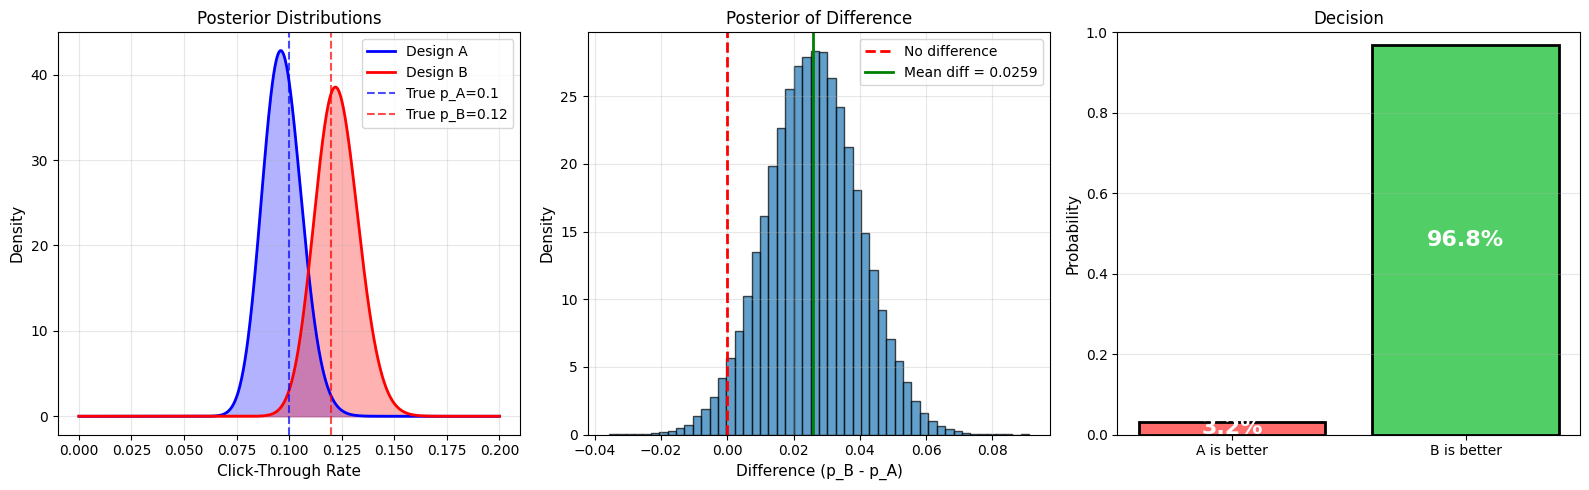


RECOMMENDATION:
  ✅ Deploy Design B (>95% certain it's better)


In [2]:
import matplotlib.pyplot as plt

# Bayesian A/B test
# Prior: Uniform (Beta(1,1)) for both
alpha_A_prior = 1
beta_A_prior = 1
alpha_B_prior = 1
beta_B_prior = 1

# Posterior: Beta(alpha + clicks, beta + (n - clicks))
alpha_A_post = alpha_A_prior + clicks_A
beta_A_post = beta_A_prior + (n_A - clicks_A)

alpha_B_post = alpha_B_prior + clicks_B
beta_B_post = beta_B_prior + (n_B - clicks_B)

print("\nBAYESIAN APPROACH")
print("-" * 70)
print(f"Posterior A: Beta({alpha_A_post}, {beta_A_post})")
print(f"  Posterior mean: {alpha_A_post/(alpha_A_post+beta_A_post):.4f}")
print(f"\nPosterior B: Beta({alpha_B_post}, {beta_B_post})")
print(f"  Posterior mean: {alpha_B_post/(alpha_B_post+beta_B_post):.4f}")

# Monte Carlo: P(p_B > p_A)
n_samples = 100000
p_A_samples = np.random.beta(alpha_A_post, beta_A_post, n_samples)
p_B_samples = np.random.beta(alpha_B_post, beta_B_post, n_samples)

prob_B_better = np.mean(p_B_samples > p_A_samples)

print(f"\nP(p_B > p_A | data) = {prob_B_better:.4f}")
print(f"\nInterpretation: There is a {prob_B_better*100:.1f}% probability that B is better than A")

# Expected lift
expected_lift = np.mean((p_B_samples - p_A_samples) / p_A_samples) * 100
print(f"Expected lift: {expected_lift:.1f}%")

# Visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

# Posterior distributions
p_values = np.linspace(0, 0.20, 1000)
posterior_A = stats.beta.pdf(p_values, alpha_A_post, beta_A_post)
posterior_B = stats.beta.pdf(p_values, alpha_B_post, beta_B_post)

ax1.plot(p_values, posterior_A, 'b-', linewidth=2, label='Design A')
ax1.plot(p_values, posterior_B, 'r-', linewidth=2, label='Design B')
ax1.fill_between(p_values, 0, posterior_A, alpha=0.3, color='blue')
ax1.fill_between(p_values, 0, posterior_B, alpha=0.3, color='red')
ax1.axvline(true_p_A, color='blue', linestyle='--', alpha=0.7, label=f'True p_A={true_p_A}')
ax1.axvline(true_p_B, color='red', linestyle='--', alpha=0.7, label=f'True p_B={true_p_B}')
ax1.set_xlabel('Click-Through Rate', fontsize=11)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title('Posterior Distributions', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Distribution of difference
diff_samples = p_B_samples - p_A_samples
ax2.hist(diff_samples, bins=50, density=True, alpha=0.7, edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='No difference')
ax2.axvline(np.mean(diff_samples), color='green', linestyle='-', linewidth=2,
           label=f'Mean diff = {np.mean(diff_samples):.4f}')
ax2.set_xlabel('Difference (p_B - p_A)', fontsize=11)
ax2.set_ylabel('Density', fontsize=11)
ax2.set_title('Posterior of Difference', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

# Probability B > A
categories = ['A is better', 'B is better']
probs = [1 - prob_B_better, prob_B_better]
colors = ['#ff6b6b', '#51cf66']

ax3.bar(categories, probs, color=colors, edgecolor='black', linewidth=2)
for i, (cat, prob) in enumerate(zip(categories, probs)):
    ax3.text(i, prob/2, f'{prob*100:.1f}%', ha='center', va='center',
            fontsize=16, fontweight='bold', color='white')
ax3.set_ylabel('Probability', fontsize=11)
ax3.set_title('Decision', fontsize=12)
ax3.set_ylim(0, 1)
ax3.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('ab_testing_bayesian.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nRECOMMENDATION:")
if prob_B_better > 0.95:
    print(f"  ✅ Deploy Design B (>95% certain it's better)")
elif prob_B_better > 0.90:
    print(f"  ⚠️ Consider deploying B (>90% certain)")
else:
    print(f"  ❌ Keep testing or stick with A")


## Application 2: Estimating Coin Fairness

### Problem

You suspect a coin might be biased. How many flips do you need to be confident?

### Sequential Testing

After  10 flips: p̂=0.500, 95% CI=[0.234, 0.766], P(fair)=0.266
After  30 flips: p̂=0.688, 95% CI=[0.520, 0.833], P(fair)=0.049
After  33 flips: p̂=0.686, 95% CI=[0.525, 0.826], P(fair)=0.045
After  49 flips: p̂=0.667, 95% CI=[0.533, 0.788], P(fair)=0.042
After  50 flips: p̂=0.673, 95% CI=[0.541, 0.792], P(fair)=0.033
After  51 flips: p̂=0.660, 95% CI=[0.529, 0.780], P(fair)=0.048
After  61 flips: p̂=0.651, 95% CI=[0.530, 0.763], P(fair)=0.049
After  62 flips: p̂=0.656, 95% CI=[0.537, 0.767], P(fair)=0.040
After  64 flips: p̂=0.652, 95% CI=[0.534, 0.761], P(fair)=0.045
After  65 flips: p̂=0.657, 95% CI=[0.540, 0.765], P(fair)=0.036
After  66 flips: p̂=0.662, 95% CI=[0.546, 0.768], P(fair)=0.029
After  67 flips: p̂=0.667, 95% CI=[0.552, 0.772], P(fair)=0.023
After  68 flips: p̂=0.657, 95% CI=[0.543, 0.763], P(fair)=0.032
After  69 flips: p̂=0.662, 95% CI=[0.549, 0.767], P(fair)=0.026
After  70 flips: p̂=0.653, 95% CI=[0.540, 0.758], P(fair)=0.036
After  71 flips: p̂=0.644, 95% CI=[0.531

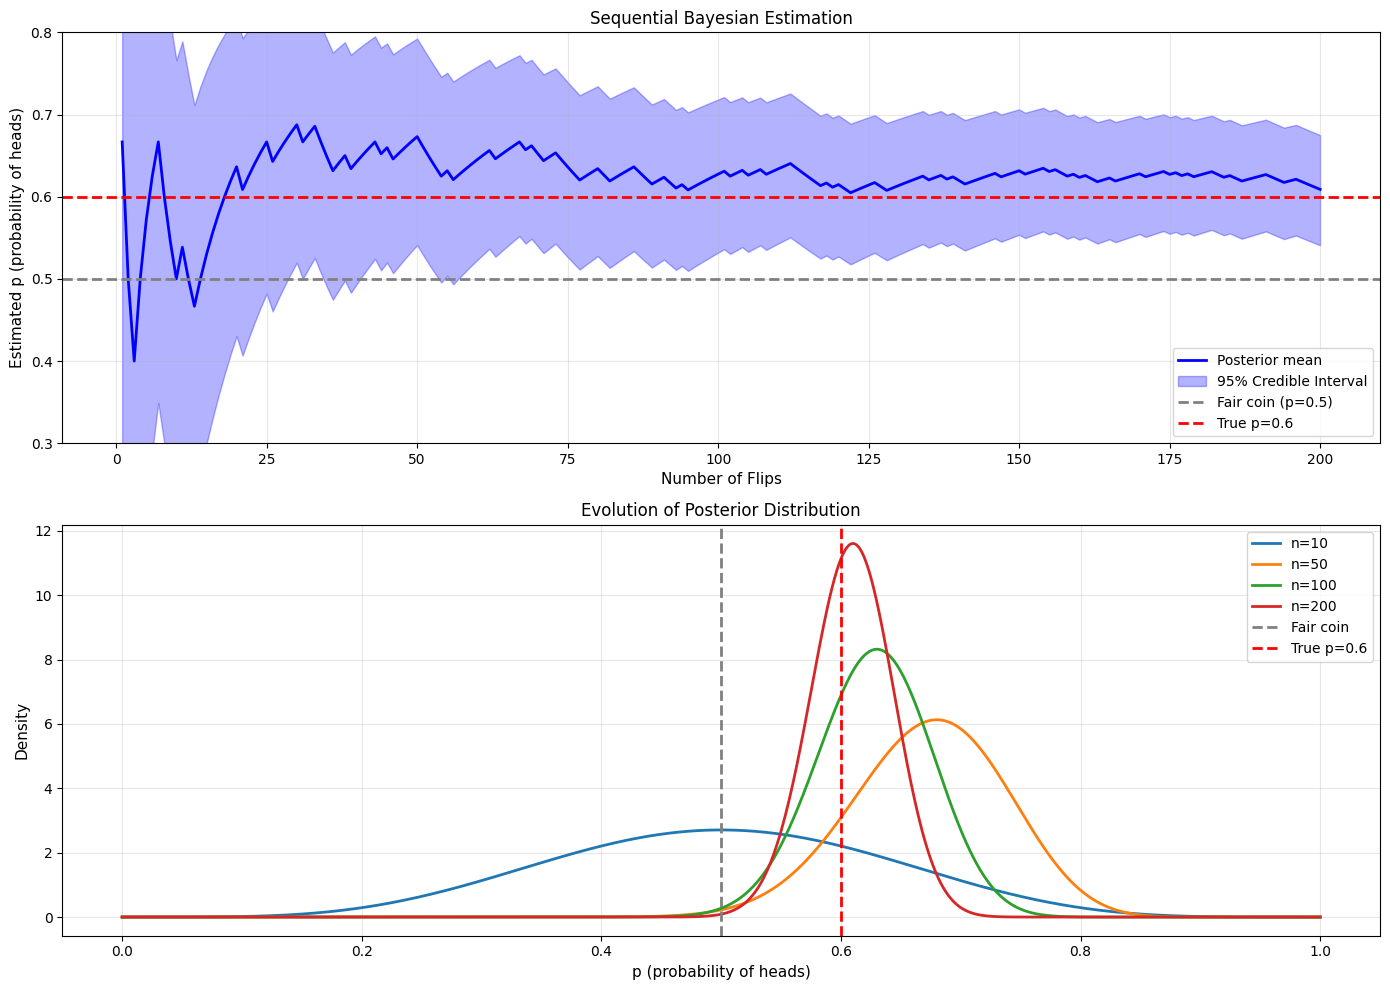

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)

# True coin bias (unknown to experimenter)
true_p = 0.6  # Biased toward heads

# Sequential experiment
max_flips = 200
flips = np.random.binomial(1, true_p, max_flips)

# Track posterior evolution
alpha = 1  # Start with uniform prior
beta = 1

posteriors = []
ci_lowers = []
ci_uppers = []
means = []

for n in range(1, max_flips + 1):
    # Update posterior
    if flips[n-1] == 1:  # Heads
        alpha += 1
    else:  # Tails
        beta += 1
    
    # Store statistics
    mean = alpha / (alpha + beta)
    ci_lower = stats.beta.ppf(0.025, alpha, beta)
    ci_upper = stats.beta.ppf(0.975, alpha, beta)
    
    means.append(mean)
    ci_lowers.append(ci_lower)
    ci_uppers.append(ci_upper)
    
    # Check if we're confident it's NOT fair (p ≠ 0.5)
    prob_fair = stats.beta.cdf(0.55, alpha, beta) - stats.beta.cdf(0.45, alpha, beta)
    
    if n in [10, 50, 100, 200] or (prob_fair < 0.05 and n > 10):
        print(f"After {n:3d} flips: p̂={mean:.3f}, 95% CI=[{ci_lower:.3f}, {ci_upper:.3f}], P(fair)={prob_fair:.3f}")

print("\nSequential Bayesian Testing")
print("="*70)

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Posterior mean with credible interval
n_range = range(1, max_flips + 1)
ax1.plot(n_range, means, 'b-', linewidth=2, label='Posterior mean')
ax1.fill_between(n_range, ci_lowers, ci_uppers, alpha=0.3, color='blue',
                  label='95% Credible Interval')
ax1.axhline(0.5, color='gray', linestyle='--', linewidth=2, label='Fair coin (p=0.5)')
ax1.axhline(true_p, color='red', linestyle='--', linewidth=2, label=f'True p={true_p}')
ax1.set_xlabel('Number of Flips', fontsize=11)
ax1.set_ylabel('Estimated p (probability of heads)', fontsize=11)
ax1.set_title('Sequential Bayesian Estimation', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)
ax1.set_ylim(0.3, 0.8)

# Posterior distributions at key points
p_vals = np.linspace(0, 1, 1000)
for n in [10, 50, 100, 200]:
    cumsum_heads = np.sum(flips[:n])
    a = 1 + cumsum_heads
    b = 1 + (n - cumsum_heads)
    posterior = stats.beta.pdf(p_vals, a, b)
    ax2.plot(p_vals, posterior, linewidth=2, label=f'n={n}')

ax2.axvline(0.5, color='gray', linestyle='--', linewidth=2, label='Fair coin')
ax2.axvline(true_p, color='red', linestyle='--', linewidth=2, label=f'True p={true_p}')
ax2.set_xlabel('p (probability of heads)', fontsize=11)
ax2.set_ylabel('Density', fontsize=11)
ax2.set_title('Evolution of Posterior Distribution', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('sequential_coin_testing.png', dpi=150, bbox_inches='tight')
plt.show()


## Application 3: Quality Control in Manufacturing

### Problem

A factory produces bolts. The diameter should be 10mm with tolerance ±0.5mm.

**Goal**: Estimate the mean and variance of bolt diameters from a sample.

### Bayesian Solution

Quality Control: Bayesian Inference
Target: 10.0 mm ± 0.5 mm
Sample size: 30
Sample mean: 10.044 mm
Sample std: 0.270 mm

Prior: Normal-Gamma(10.0, 1, 3, 1.0)
Posterior: Normal-Gamma(10.042, 31, 18.0, 2.058)

Process Mean (μ):
  Estimate: 10.042 mm
  95% CI: [9.919, 10.165] mm

P(process mean within spec) = 1.000

Process Variance (σ²):
  Estimate: 0.121
  Std Dev: 0.348 mm

Predicted proportion of future bolts in spec: 84.3%
  ⚠️ WARNING: Process may need adjustment!


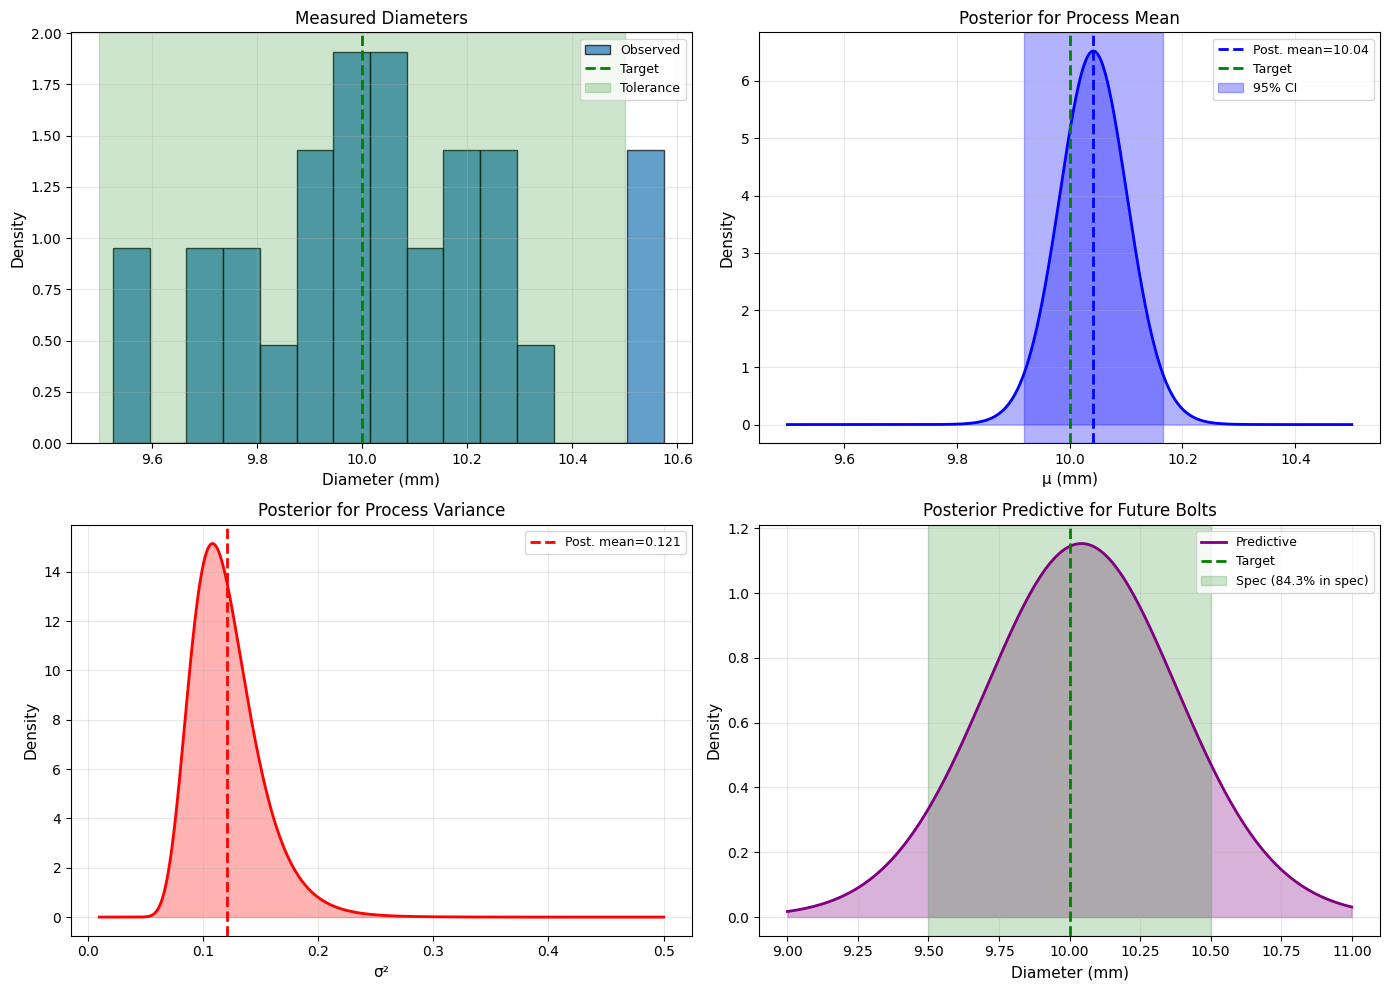

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)

# True process parameters (unknown)
true_mu = 10.1  # Slightly off target
true_sigma = 0.3

# Sample bolts
n = 30
measurements = np.random.normal(true_mu, true_sigma, n)

print("Quality Control: Bayesian Inference")
print("="*70)
print(f"Target: 10.0 mm ± 0.5 mm")
print(f"Sample size: {n}")
print(f"Sample mean: {np.mean(measurements):.3f} mm")
print(f"Sample std: {np.std(measurements, ddof=1):.3f} mm")
print()

# Weakly informative prior (centered on target)
mu_0 = 10.0  # Target diameter
kappa_0 = 1  # Low confidence
alpha = 3    # Weak prior for variance
beta = 0.5 * (alpha - 1)  # Prior mean variance ~ 0.25

# Data summaries
xbar = np.mean(measurements)
ss = np.sum((measurements - xbar)**2)

# Posterior parameters
kappa_n = kappa_0 + n
mu_n = (kappa_0 * mu_0 + n * xbar) / kappa_n
alpha_n = alpha + n/2
beta_n = beta + 0.5*ss + (kappa_0*n*(xbar - mu_0)**2)/(2*kappa_n)

print(f"Prior: Normal-Gamma({mu_0}, {kappa_0}, {alpha}, {beta})")
print(f"Posterior: Normal-Gamma({mu_n:.3f}, {kappa_n}, {alpha_n:.1f}, {beta_n:.3f})")
print()

# Marginal posterior for mu
df_mu = 2 * alpha_n
scale_mu = np.sqrt(beta_n / (alpha_n * kappa_n))
ci_mu_lower = stats.t.ppf(0.025, df_mu, loc=mu_n, scale=scale_mu)
ci_mu_upper = stats.t.ppf(0.975, df_mu, loc=mu_n, scale=scale_mu)

print(f"Process Mean (μ):")
print(f"  Estimate: {mu_n:.3f} mm")
print(f"  95% CI: [{ci_mu_lower:.3f}, {ci_mu_upper:.3f}] mm")

# Check if within tolerance
target = 10.0
tolerance = 0.5
prob_in_spec = stats.t.cdf(target + tolerance, df_mu, loc=mu_n, scale=scale_mu) - \
               stats.t.cdf(target - tolerance, df_mu, loc=mu_n, scale=scale_mu)

print(f"\nP(process mean within spec) = {prob_in_spec:.3f}")

# Marginal posterior for sigma^2
sigma2_mean = beta_n / (alpha_n - 1)
print(f"\nProcess Variance (σ²):")
print(f"  Estimate: {sigma2_mean:.3f}")
print(f"  Std Dev: {np.sqrt(sigma2_mean):.3f} mm")

# Predictive: What proportion of future bolts will be in spec?
df_pred = 2 * alpha_n
scale_pred = np.sqrt(beta_n * (kappa_n + 1) / (alpha_n * kappa_n))

prob_future_in_spec = stats.t.cdf(target + tolerance, df_pred, loc=mu_n, scale=scale_pred) - \
                      stats.t.cdf(target - tolerance, df_pred, loc=mu_n, scale=scale_pred)

print(f"\nPredicted proportion of future bolts in spec: {prob_future_in_spec*100:.1f}%")

if prob_future_in_spec < 0.95:
    print("  ⚠️ WARNING: Process may need adjustment!")
else:
    print("  ✅ Process is within acceptable limits")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Measurements
axes[0,0].hist(measurements, bins=15, density=True, alpha=0.7, edgecolor='black',
              label='Observed')
x = np.linspace(9, 11, 100)
axes[0,0].axvline(target, color='green', linestyle='--', linewidth=2, label='Target')
axes[0,0].axvspan(target-tolerance, target+tolerance, alpha=0.2, color='green',
                  label='Tolerance')
axes[0,0].set_xlabel('Diameter (mm)', fontsize=11)
axes[0,0].set_ylabel('Density', fontsize=11)
axes[0,0].set_title('Measured Diameters', fontsize=12)
axes[0,0].legend(fontsize=9)
axes[0,0].grid(alpha=0.3)

# Posterior for mu
mu_vals = np.linspace(9.5, 10.5, 1000)
posterior_mu = stats.t.pdf(mu_vals, df_mu, loc=mu_n, scale=scale_mu)
axes[0,1].fill_between(mu_vals, 0, posterior_mu, alpha=0.3, color='blue')
axes[0,1].plot(mu_vals, posterior_mu, 'b-', linewidth=2)
axes[0,1].axvline(mu_n, color='blue', linestyle='--', linewidth=2,
                 label=f'Post. mean={mu_n:.2f}')
axes[0,1].axvline(target, color='green', linestyle='--', linewidth=2, label='Target')
axes[0,1].axvspan(ci_mu_lower, ci_mu_upper, alpha=0.3, color='blue',
                  label='95% CI')
axes[0,1].set_xlabel('μ (mm)', fontsize=11)
axes[0,1].set_ylabel('Density', fontsize=11)
axes[0,1].set_title('Posterior for Process Mean', fontsize=12)
axes[0,1].legend(fontsize=9)
axes[0,1].grid(alpha=0.3)

# Posterior for sigma^2
sigma2_vals = np.linspace(0.01, 0.5, 1000)
posterior_sigma2 = stats.invgamma.pdf(sigma2_vals, alpha_n, scale=beta_n)
axes[1,0].fill_between(sigma2_vals, 0, posterior_sigma2, alpha=0.3, color='red')
axes[1,0].plot(sigma2_vals, posterior_sigma2, 'r-', linewidth=2)
axes[1,0].axvline(sigma2_mean, color='red', linestyle='--', linewidth=2,
                 label=f'Post. mean={sigma2_mean:.3f}')
axes[1,0].set_xlabel('σ²', fontsize=11)
axes[1,0].set_ylabel('Density', fontsize=11)
axes[1,0].set_title('Posterior for Process Variance', fontsize=12)
axes[1,0].legend(fontsize=9)
axes[1,0].grid(alpha=0.3)

# Predictive distribution
predictive_vals = np.linspace(9, 11, 1000)
predictive = stats.t.pdf(predictive_vals, df_pred, loc=mu_n, scale=scale_pred)
axes[1,1].fill_between(predictive_vals, 0, predictive, alpha=0.3, color='purple')
axes[1,1].plot(predictive_vals, predictive, 'purple', linewidth=2, label='Predictive')
axes[1,1].axvline(target, color='green', linestyle='--', linewidth=2, label='Target')
axes[1,1].axvspan(target-tolerance, target+tolerance, alpha=0.2, color='green',
                  label=f'Spec ({prob_future_in_spec*100:.1f}% in spec)')
axes[1,1].set_xlabel('Diameter (mm)', fontsize=11)
axes[1,1].set_ylabel('Density', fontsize=11)
axes[1,1].set_title('Posterior Predictive for Future Bolts', fontsize=12)
axes[1,1].legend(fontsize=9)
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('quality_control_bayesian.png', dpi=150, bbox_inches='tight')
plt.show()


## Application 4: Email Spam Rate Estimation

### Problem

Estimate spam rate in email with limited data and update as new emails arrive.

Email Spam Rate: Sequential Bayesian Updating
Prior belief: Beta(7, 13)
Prior mean: 0.350

After  10 emails: Beta( 10,  20), mean=0.333, 95% CI=[0.179, 0.508]
After  30 emails: Beta( 21,  29), mean=0.420, 95% CI=[0.288, 0.558]
After  80 emails: Beta( 41,  59), mean=0.410, 95% CI=[0.316, 0.507]
After 180 emails: Beta( 79, 121), mean=0.395, 95% CI=[0.328, 0.463]
After 380 emails: Beta(160, 240), mean=0.400, 95% CI=[0.353, 0.448]


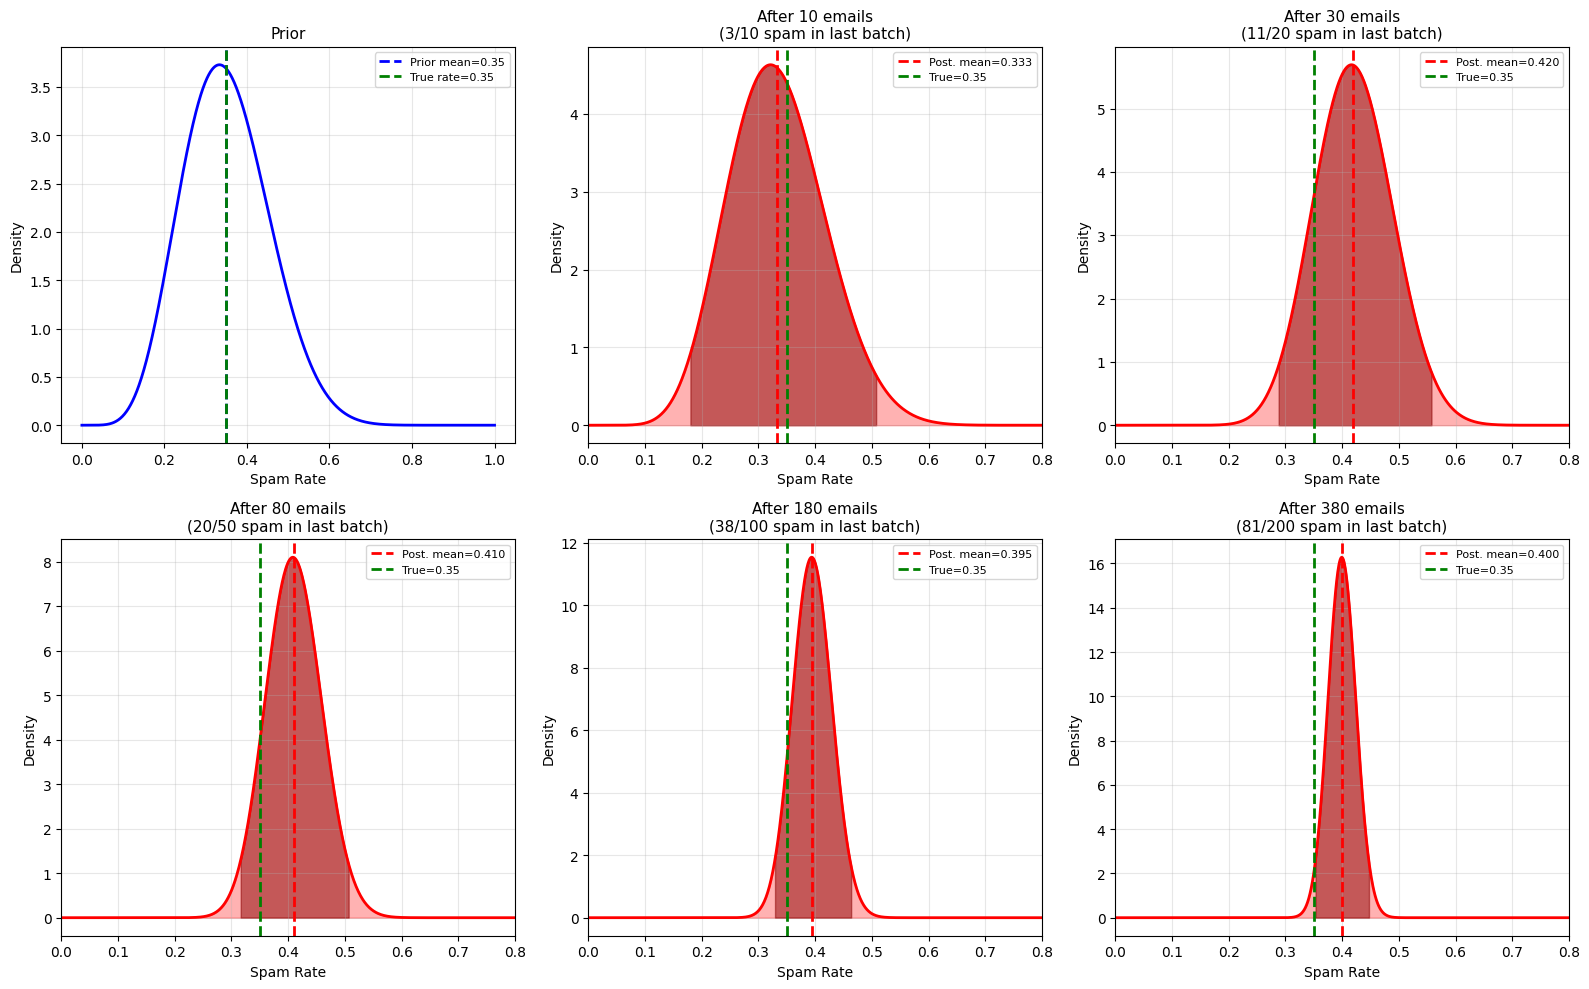

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)

print("Email Spam Rate: Sequential Bayesian Updating")
print("="*70)

# True spam rate (unknown)
true_spam_rate = 0.35

# Prior based on historical data: Beta(7, 13)
# Corresponds to previous belief: ~35% spam, moderate confidence
alpha_prior = 7
beta_prior = 13

print(f"Prior belief: Beta({alpha_prior}, {beta_prior})")
print(f"Prior mean: {alpha_prior/(alpha_prior+beta_prior):.3f}")
print()

# Simulate checking emails in batches
batches = [10, 20, 50, 100, 200]
alpha = alpha_prior
beta = beta_prior

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

p_vals = np.linspace(0, 1, 1000)

# Plot prior
prior = stats.beta.pdf(p_vals, alpha_prior, beta_prior)
axes[0].plot(p_vals, prior, 'b-', linewidth=2)
axes[0].axvline(alpha_prior/(alpha_prior+beta_prior), color='blue',
               linestyle='--', linewidth=2,
               label=f'Prior mean={alpha_prior/(alpha_prior+beta_prior):.2f}')
axes[0].axvline(true_spam_rate, color='green', linestyle='--', linewidth=2,
               label=f'True rate={true_spam_rate}')
axes[0].set_xlabel('Spam Rate', fontsize=10)
axes[0].set_ylabel('Density', fontsize=10)
axes[0].set_title('Prior', fontsize=11)
axes[0].legend(fontsize=8)
axes[0].grid(alpha=0.3)

# Process batches
total_emails = 0
for idx, batch_size in enumerate(batches):
    # Simulate new emails
    new_spam = np.random.binomial(batch_size, true_spam_rate)
    
    # Update posterior
    alpha += new_spam
    beta += (batch_size - new_spam)
    total_emails += batch_size
    
    # Posterior
    posterior = stats.beta.pdf(p_vals, alpha, beta)
    post_mean = alpha / (alpha + beta)
    ci_lower = stats.beta.ppf(0.025, alpha, beta)
    ci_upper = stats.beta.ppf(0.975, alpha, beta)
    
    # Plot
    ax = axes[idx + 1]
    ax.fill_between(p_vals, 0, posterior, alpha=0.3, color='red')
    ax.plot(p_vals, posterior, 'r-', linewidth=2)
    ax.axvline(post_mean, color='red', linestyle='--', linewidth=2,
              label=f'Post. mean={post_mean:.3f}')
    ax.axvline(true_spam_rate, color='green', linestyle='--', linewidth=2,
              label=f'True={true_spam_rate}')
    ax.fill_between(p_vals[(p_vals >= ci_lower) & (p_vals <= ci_upper)],
                     0,
                     posterior[(p_vals >= ci_lower) & (p_vals <= ci_upper)],
                     alpha=0.5, color='darkred')
    ax.set_xlabel('Spam Rate', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'After {total_emails} emails\n({new_spam}/{batch_size} spam in last batch)',
                fontsize=11)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    ax.set_xlim(0, 0.8)
    
    print(f"After {total_emails:3d} emails: Beta({alpha:3d}, {beta:3d}), "
          f"mean={post_mean:.3f}, 95% CI=[{ci_lower:.3f}, {ci_upper:.3f}]")

plt.tight_layout()
plt.savefig('spam_rate_sequential.png', dpi=150, bbox_inches='tight')
plt.show()


## Application 5: Machine Learning - Hyperparameter Tuning

### Problem

Estimate the optimal learning rate for a neural network using Bayesian optimization.

Bayesian Hyperparameter Optimization
Goal: Find optimal learning rate for neural network

Try LR=0.0381: Performance=0.962
Try LR=0.0164: Performance=1.000
Try LR=0.0068: Performance=1.000
Try LR=0.0711: Performance=0.946
Try LR=0.0030: Performance=0.987

Switch to Bayesian optimization...

Iteration 1: LR=0.0112, Performance=0.989
Iteration 2: LR=0.0072, Performance=0.948
Iteration 3: LR=0.0259, Performance=1.000
Iteration 4: LR=0.0012, Performance=0.990
Iteration 5: LR=0.0090, Performance=0.986
Iteration 6: LR=0.0010, Performance=0.986
Iteration 7: LR=0.0224, Performance=1.000
Iteration 8: LR=0.0204, Performance=1.000
Iteration 9: LR=0.0113, Performance=0.988
Iteration 10: LR=0.0259, Performance=1.000

Best learning rate found: 0.0164
Best performance: 1.000


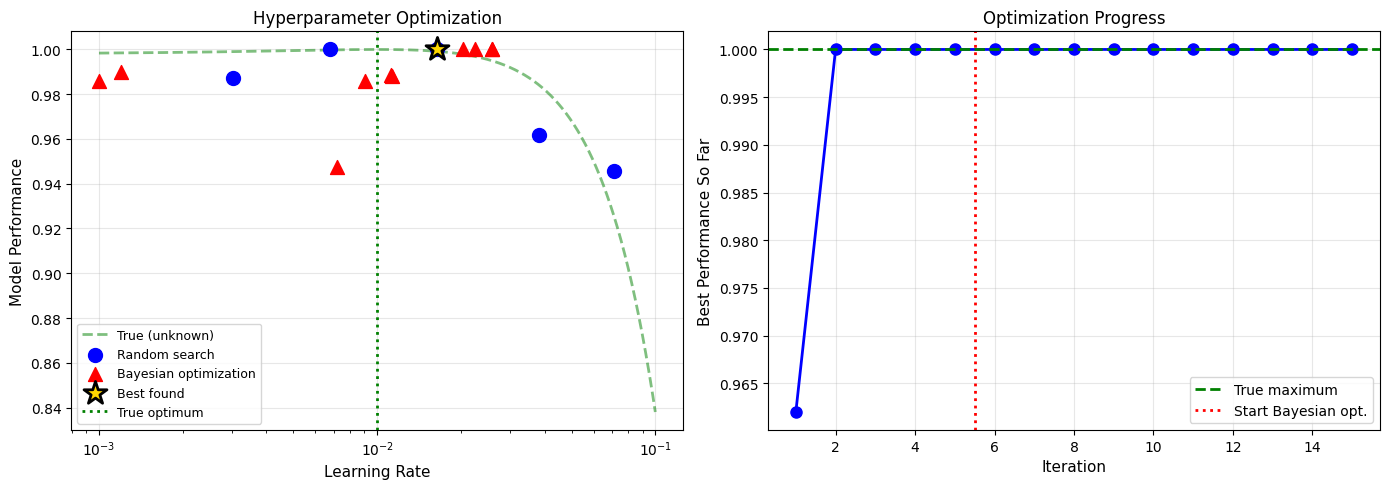

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)

def objective_function(learning_rate):
    """
    Simulated model performance (unknown in practice).
    True optimum around 0.01
    """
    optimal_lr = 0.01
    # Gaussian-like performance with noise
    noise = np.random.normal(0, 0.02)
    performance = 1.0 - 20 * (learning_rate - optimal_lr)**2 + noise
    return np.clip(performance, 0, 1)

print("Bayesian Hyperparameter Optimization")
print("="*70)
print("Goal: Find optimal learning rate for neural network")
print()

# Observations
lr_tested = []
performance = []

# Initial random samples
for _ in range(5):
    lr = np.random.uniform(0.001, 0.1)
    perf = objective_function(lr)
    lr_tested.append(lr)
    performance.append(perf)
    print(f"Try LR={lr:.4f}: Performance={perf:.3f}")

print("\nSwitch to Bayesian optimization...")
print()

# Fit Gaussian Process (simplified: use Normal approximation)
# In practice, use GPyOpt or similar
for iteration in range(10):
    # Simple acquisition: expected improvement
    # Here we use a simplified version
    
    # Try learning rate that maximizes expected performance
    # based on current data
    lr_candidates = np.linspace(0.001, 0.1, 100)
    
    # Simple model: higher performance regions more likely
    weights = np.array(performance)
    weights = weights / np.sum(weights)
    
    # Sample from weighted distribution of successful regions
    best_idx = np.argmax(performance)
    best_lr = lr_tested[best_idx]
    
    # Explore around best + some randomness
    lr_new = best_lr + np.random.normal(0, 0.01)
    lr_new = np.clip(lr_new, 0.001, 0.1)
    
    perf_new = objective_function(lr_new)
    lr_tested.append(lr_new)
    performance.append(perf_new)
    
    if perf_new > np.max(performance[:-1]):
        print(f"Iteration {iteration+1}: LR={lr_new:.4f}, Performance={perf_new:.3f} ⭐ NEW BEST")
    else:
        print(f"Iteration {iteration+1}: LR={lr_new:.4f}, Performance={perf_new:.3f}")

# Results
best_idx = np.argmax(performance)
print(f"\nBest learning rate found: {lr_tested[best_idx]:.4f}")
print(f"Best performance: {performance[best_idx]:.3f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# True function and tested points
lr_range = np.linspace(0.001, 0.1, 1000)
true_performance = [1.0 - 20*(lr - 0.01)**2 for lr in lr_range]

ax1.plot(lr_range, true_performance, 'g--', linewidth=2, alpha=0.5,
        label='True (unknown)')
ax1.scatter(lr_tested[:5], performance[:5], s=100, c='blue',
           marker='o', label='Random search', zorder=5)
ax1.scatter(lr_tested[5:], performance[5:], s=100, c='red',
           marker='^', label='Bayesian optimization', zorder=5)
ax1.scatter(lr_tested[best_idx], performance[best_idx], s=300, c='gold',
           marker='*', edgecolor='black', linewidth=2,
           label='Best found', zorder=10)
ax1.axvline(0.01, color='green', linestyle=':', linewidth=2,
           label='True optimum')
ax1.set_xlabel('Learning Rate', fontsize=11)
ax1.set_ylabel('Model Performance', fontsize=11)
ax1.set_title('Hyperparameter Optimization', fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)
ax1.set_xscale('log')

# Performance over iterations
max_so_far = []
current_max = 0
for perf in performance:
    current_max = max(current_max, perf)
    max_so_far.append(current_max)

ax2.plot(range(1, len(performance)+1), max_so_far, 'b-o', linewidth=2,
        markersize=8)
ax2.axhline(max(true_performance), color='green', linestyle='--',
           linewidth=2, label='True maximum')
ax2.axvline(5.5, color='red', linestyle=':', linewidth=2,
           label='Start Bayesian opt.')
ax2.set_xlabel('Iteration', fontsize=11)
ax2.set_ylabel('Best Performance So Far', fontsize=11)
ax2.set_title('Optimization Progress', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('hyperparameter_optimization.png', dpi=150, bbox_inches='tight')
plt.show()


## Summary

### Key Applications Covered

1. **A/B Testing**: Bayesian approach gives probability statements
2. **Sequential Testing**: Update beliefs as data arrives
3. **Quality Control**: Combine prior knowledge with measurements
4. **Spam Detection**: Online learning from streaming data
5. **Hyperparameter Tuning**: Efficient exploration of parameter space

### Why Bayesian Methods Excel

✅ **Small Data**: Prior knowledge regularizes estimates  
✅ **Sequential Data**: Natural online updating  
✅ **Decision Making**: Direct probability statements  
✅ **Uncertainty Quantification**: Full posterior distributions  
✅ **Prior Knowledge**: Incorporate domain expertise  

### Practical Considerations

**When to use Bayesian inference**:
- Small to moderate datasets
- Strong prior knowledge available
- Need probability statements (not just p-values)
- Sequential/online learning scenarios
- Cost of being wrong is high

**When MLE might be better**:
- Very large datasets (prior becomes irrelevant)
- No prior knowledge (but can use uniform prior)
- Computational constraints (MLE usually faster)
- Peer community expects frequentist methods

### Modern Tools

In [ ]:
# For complex Bayesian models
import pymc  # Probabilistic programming
import stan  # Another popular framework
import arviz  # Visualization and diagnostics

# For Bayesian ML
from sklearn.gaussian_process import GaussianProcessRegressor
import gpytorch  # Deep GPs
import gpyopt  # Bayesian optimization



## Final Thoughts

Parameter estimation is fundamental to:
- **Statistics**: Understanding populations from samples
- **Machine Learning**: Training models from data
- **Science**: Estimating physical constants
- **Engineering**: System identification and control

Both **MLE** and **Bayesian** approaches are valuable:
- MLE: Simple, efficient, widely accepted
- Bayesian: Flexible, principled, quantifies uncertainty

Choose based on your problem, data size, and available prior knowledge!